In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

GUROBI_TIMER = 3600

In [2]:
def stock_selection(input_stock, m):
    '''
    Optmization function to select 'm' stocks from the dataset 'input_stock' with 'num_stocks' stocks
    '''
    input_stock = input_stock.drop('NDX',axis=1)

    # Changing Price to percentage 
    input_stock = input_stock.pct_change().dropna()

    # Creating Correlation Matrix
    corr_mat = input_stock.corr()
    num_stocks = corr_mat.shape[0]
    
    # Setting up the Objective function
    obj = (corr_mat.to_numpy().flatten())
    obj = np.concatenate([obj,np.zeros(num_stocks)])
    num_var = len(obj)

    df = pd.DataFrame(index=input_stock.columns, columns = input_stock.columns)
    df.fillna(0,inplace=True)
    
    A = np.zeros((1+num_stocks+(num_stocks**2),num_var))

    # 1st constraint
    A[0][-num_stocks:] = 1

    # 2nd constraint
    for i in range(1, num_stocks+1):
        df1 = df.copy()
        df1.iloc[i-1] = 1
        A[i] = np.concatenate([df1.to_numpy().flatten(),np.zeros(num_stocks)])

    x = np.zeros(num_stocks)
    # 3rd constraint
    for j in range(0, num_stocks):
        for k in range(0, num_stocks):    
            df1 = df.copy()
            df1.iloc[j,k] = 1

            x1 = x.copy()
            x1[k] = -1

            A[i+1] = np.concatenate([df1.to_numpy().flatten(),x1])
            i = i+1
    
    # RHS values
    b = [m] + [1]*num_stocks + [0]*(num_stocks**2)
    
    # Sense matrix
    sense = ['='] + ['=']*num_stocks + ['<']*(num_stocks**2)    
    
    lpMod = gp.Model()
    lpMod_x = lpMod.addMVar(len(obj),vtype=['B']*len(obj)) # 'C' or 'I' or 'B'
    lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
    lpMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    lpMod.optimize()
    
    return input_stock, lpMod_x.x

In [3]:
# Reading data for 2019 stocks
input_stock = pd.read_csv('stocks2019.csv')
input_stock.X = pd.to_datetime(input_stock.X)
input_stock = input_stock.set_index('X')
q2019 = input_stock.pct_change()["NDX"][1:]
r2019 = input_stock.pct_change().drop("NDX", axis = 1)[1:]
r2019.style.format('{:,.2%}')

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,AMAT,ASML,ADSK,ADP,BIDU,BIIB,BMRN,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTXS,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,EXPE,FB,FAST,FISV,GILD,IDXX,ILMN,INCY,INTC,INTU,ISRG,JD,KLAC,KHC,LRCX,LBTYA,LBTYK,LULU,MAR,MXIM,MELI,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,PCAR,PAYX,PYPL,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TTWO,TSLA,TXN,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00,-3.55%,-3.95%,-9.45%,2.20%,-8.58%,-2.77%,-2.85%,-2.52%,-1.52%,-6.04%,-3.75%,-9.96%,-5.79%,-5.52%,-5.51%,-3.02%,-4.65%,0.76%,-0.89%,-3.40%,-8.90%,-3.93%,-2.58%,-2.26%,-0.17%,-1.11%,-1.60%,-3.64%,-1.44%,-3.15%,0.79%,-1.66%,-2.12%,-1.57%,-2.54%,-4.88%,-0.48%,-1.84%,-2.07%,0.11%,-3.09%,-2.90%,-2.84%,-2.91%,2.85%,-2.43%,-3.49%,7.08%,-5.50%,-3.06%,-3.39%,-4.33%,-5.61%,-0.07%,-4.82%,0.14%,-0.63%,0.82%,-5.32%,-5.68%,-0.48%,-7.05%,-5.34%,-3.68%,1.11%,-0.38%,-1.56%,-3.85%,1.32%,-6.04%,-4.08%,1.46%,-2.32%,-1.69%,-4.27%,-0.93%,-3.11%,-2.96%,-0.10%,-0.84%,-1.95%,0.68%,-10.65%,-2.43%,-4.34%,-3.50%,-0.37%,-4.67%,-3.15%,-5.90%,-2.28%,-1.86%,-3.50%,-3.06%,-0.21%,-1.04%,-3.58%,-6.82%,-0.39%,-3.77%
2019-01-04 00:00:00,3.99%,4.86%,11.44%,5.78%,1.04%,5.13%,5.38%,5.01%,3.42%,2.43%,4.37%,4.27%,6.85%,4.33%,5.28%,3.99%,4.03%,3.69%,3.44%,3.27%,0.98%,4.17%,0.97%,3.02%,5.30%,2.93%,4.70%,4.50%,1.89%,4.26%,3.38%,3.56%,2.90%,2.97%,3.55%,5.33%,2.35%,2.30%,7.25%,1.13%,4.21%,4.71%,4.10%,4.44%,4.60%,5.29%,6.49%,6.19%,6.14%,3.97%,4.76%,9.43%,6.40%,2.72%,4.88%,6.45%,6.85%,3.37%,5.97%,4.40%,6.32%,4.06%,5.48%,4.65%,9.42%,2.77%,3.73%,4.01%,9.72%,6.41%,4.84%,-1.25%,4.44%,3.49%,5.09%,2.05%,5.44%,1.62%,6.85%,2.72%,5.62%,3.87%,4.79%,7.17%,3.32%,3.44%,3.80%,2.57%,5.77%,4.52%,5.90%,4.80%,4.47%,4.41%,5.48%,3.33%,6.06%,4.24%,0.98%,4.63%
2019-01-07 00:00:00,2.82%,1.36%,8.26%,1.83%,1.72%,-0.20%,-0.22%,3.44%,1.35%,0.63%,2.55%,-0.22%,1.78%,2.28%,3.46%,-0.54%,1.03%,1.28%,3.55%,-0.33%,2.04%,0.37%,-0.40%,-0.57%,-0.42%,-0.46%,0.17%,0.68%,0.40%,-0.16%,-1.06%,0.56%,0.37%,-0.54%,11.79%,1.93%,5.46%,1.73%,3.76%,0.18%,1.30%,0.07%,0.73%,-0.20%,0.45%,-0.29%,1.72%,2.68%,0.47%,1.53%,1.43%,2.20%,1.42%,1.89%,0.89%,-4.79%,-4.28%,4.32%,0.19%,1.04%,4.32%,2.93%,3.98%,0.13%,-4.07%,0.69%,-0.12%,4.24%,5.97%,5.29%,0.74%,-0.62%,-0.12%,-0.53%,0.77%,-0.86%,2.29%,-0.28%,-0.23%,4.21%,5.68%,0.81%,1.35%,4.50%,0.00%,2.22%,1.41%,2.66%,5.44%,1.72%,2.21%,6.26%,1.63%,0.10%,1.82%,0.57%,0.09%,3.55%,-0.43%,2.64%
2019-01-08 00:00:00,3.03%,1.49%,0.88%,0.62%,1.60%,0.88%,0.74%,1.66%,1.28%,2.44%,0.50%,1.91%,-4.05%,-0.74%,0.87%,0.59%,0.49%,0.63%,2.34%,-1.45%,-0.80%,0.58%,3.48%,2.31%,-0.25%,2.57%,1.08%,0.81%,0.78%,1.13%,0.82%,1.64%,0.75%,1.44%,1.21%,0.94%,0.65%,1.80%,1.63%,1.54%,2.10%,3.25%,2.60%,0.66%,-0.69%,1.28%,-4.59%,0.93%,0.63%,2.40%,0.95%,0.83%,-1.59%,0.09%,-1.69%,-4.24%,-3.61%,1.31%,1.62%,-1.50%,-0.14%,2.72%,-0.76%,0.73%,4.18%,2.33%,6.23%,1.22%,1.56%,-2.49%,0.57%,-1.07%,0.97%,0.76%,2.04%,0.96%,3.40%,-0.87%,0.16%,2.93%,6.85%,2.09%,1.09%,1.94%,0.08%,0.40%,-0.98%,3.36%,0.12%,-0.13%,1.03%,1.85%,3.65%,0.89%,1.33%,2.00%,2.11%,-0.96%,1.16%,-1.91%
2019-01-09 00:00:00,1.72%,1.18%,-2.70%,1.24%,3.82%,-0.34%,-0.15%,0.17%,-0.12%,2.53%,1.75%,1.70%,4.22%,4.15%,2.17%,0.09%,1.98%,0.68%,-1.56%,-2.22%,4.32%,0.41%,1.32%,0.56%,-1.02%,-0.07%,0.88%,-0.55%,0.93%,-0.09%,0.95%,1.35%,0.65%,0.99%,5.50%,1.40%,-1.45%,0.97%,-0.12%,-0.82%,-2.01%,1.19%,0.28%,-0.31%,-0.22%,1.55%,3.91%,-1.60%,0.57%,-0.31%,7.06%,3.22%,2.58%,-0.53%,5.16%,0.72%,0.30%,0.10%,-0.51%,2.71%,3.49%,3.96%,5.04%,1.43%,-3.66%,-0.36%,0.95%,6.61%,-0.10%,1.97%,4.58%,2.22%,-1.51%,-0.06%,0.96%,-2.79%,6.42%,1.18%,0.58%,-1.31%,3.20%,-4.57%,3.83%,0.71%,0.41%,1.00%,-0.07%,-0.43%,0.95%,1.97%,2.37%,1.88%,-0.82%,0.38%,2.31%,1.21%,-0.46%,4.41%,-0.80%,0.90%
2019-01-10 00:00:00,1.02%,0.99%,-2.23%,0.88%,1.16%,-0.26%,-0.40%,-0.19%,1.15%,1.38%,1.30%,0.32%,1.34%,-0.19%,-0.04%,0.79%,1.03%,1.40%,3.39%,1.69

In [4]:
# To select top 5 stocks 
m = 5

# optimize for fund selection
final_stocks, obj_x = stock_selection(input_stock, m)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-22


In [5]:
solution = final_stocks.columns[obj_x[-final_stocks.shape[1]:]==1]
# selected stocks
solution

Index(['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL'], dtype='object')

In [6]:
# function to caluculate weights of stocks
def calculated_weights(input_stock, m, solution):
    
    # Calculating percentage change
    input_stock = input_stock.pct_change().dropna()
    A = np.zeros(((2*input_stock.shape[0])+1,input_stock.shape[0]+m))
    q = []
    n = input_stock.shape[0]
    
    # 1st constraint  
    for i in range(n):
        q.append(input_stock.iloc[i]['NDX'])
        A[i][i] = 1
        A[i+n][i] = 1
        A[i][-m:] = input_stock.iloc[i][solution.values]
        A[i+n][-m:] = -input_stock.iloc[i][solution.values]
    
    # 2nd constraint
    A[-1][-m:] = 1 
    
    # RHS values
    q_1 = [-1*x for x in q]
    b = q + q_1 + [1]

    # Setting up the Objective
    obj = [1]*(input_stock.shape[0])+[0]*m
    obj = np.array(obj)
    b = np.array(b)
    
    # Sense matrix
    sense = ['>']*(2*n) + ['=']
    
    sense = np.array(sense)
    lpMod = gp.Model()
    lpMod_x = lpMod.addMVar(len(obj)) # 'C' or 'I' or 'B'
    lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
    lpMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    lpMod.optimize()
    
    return pd.DataFrame(lpMod_x.x[-m:],index=solution,columns=['Weights']), lpMod.objVal

In [7]:
weights,obj_val = calculated_weights(input_stock, m, solution)
weights = pd.DataFrame(weights[-m:],index=solution,columns=['Weights'])
# displaying the calculated weights
weights

,Weights
LBTYK,0.048862
MXIM,0.210388
MSFT,0.580352
VRTX,0.071190
XEL,0.089208


In [8]:
## Read 2020 stocks data to track error

s_2020 = pd.read_csv('stocks2020.csv')
s_2020 = s_2020.set_index('X')
s_2020.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2020-01-02,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,235.229111,...,36.970001,254.550003,196.729996,150.376770,219.449997,57.253372,167.460007,64.771545,61.184597,100.399811
2020-01-03,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,233.632172,...,36.180000,250.169998,200.880005,151.839554,217.979996,57.253372,168.440002,63.774597,61.478848,98.088585
2020-01-06,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,235.425064,...,35.689999,250.949997,202.740005,152.187836,224.029999,57.747601,169.490005,62.550629,61.390568,96.044044
2020-01-07,8846.450195,59.945747,333.390015,48.250000,106.849998,283.059998,1395.109985,1393.339966,1906.859985,233.210892,...,37.330002,253.089996,203.210007,153.461548,223.789993,57.456879,172.949997,66.785164,61.263062,98.236748
2020-01-08,8912.370117,59.488754,337.869995,47.830002,108.580002,286.000000,1405.040039,1404.319946,1891.969971,233.387253,...,36.869999,258.000000,204.149994,154.874542,231.089996,54.103855,178.710007,67.752487,61.204208,97.960182


In [9]:
# compare selected weighted stocks to the NASDAQ index to track error
def portfolio_error(input_stock, weights):
    
    labels = weights.index.to_list()
    returns = input_stock[['NDX']+labels].pct_change().dropna()
    returns['fund'] = returns[labels]@weights
    returns['diff'] = abs(returns['NDX'] - returns['fund'])
    
    return returns

# plot graph of the tracked error
def track_portfolio(input_stock, weights, year):

    labels = weights.index.to_list()
    input_stocks_copy = input_stock[['NDX']+labels]

    input_stocks_copy['fund'] = input_stocks_copy[labels]@weights
    scale = input_stocks_copy['NDX'][0]/input_stocks_copy['fund'][0]
    input_stocks_copy['fund'] = input_stocks_copy['fund'] * scale
    
    plt.style.use('ggplot')
    input_stocks_copy[['NDX','fund']].plot(kind='line', figsize=(20,10))
    plt.legend(prop={'size': 18})

    plt.title(f'Comparing NDX with m={m} stocks for year {year}')
    plt.xlabel('Date', fontsize=18)

Tracking error for 2020:  0.8696699433741901
Tracking error for 2019:  0.7891782824631476


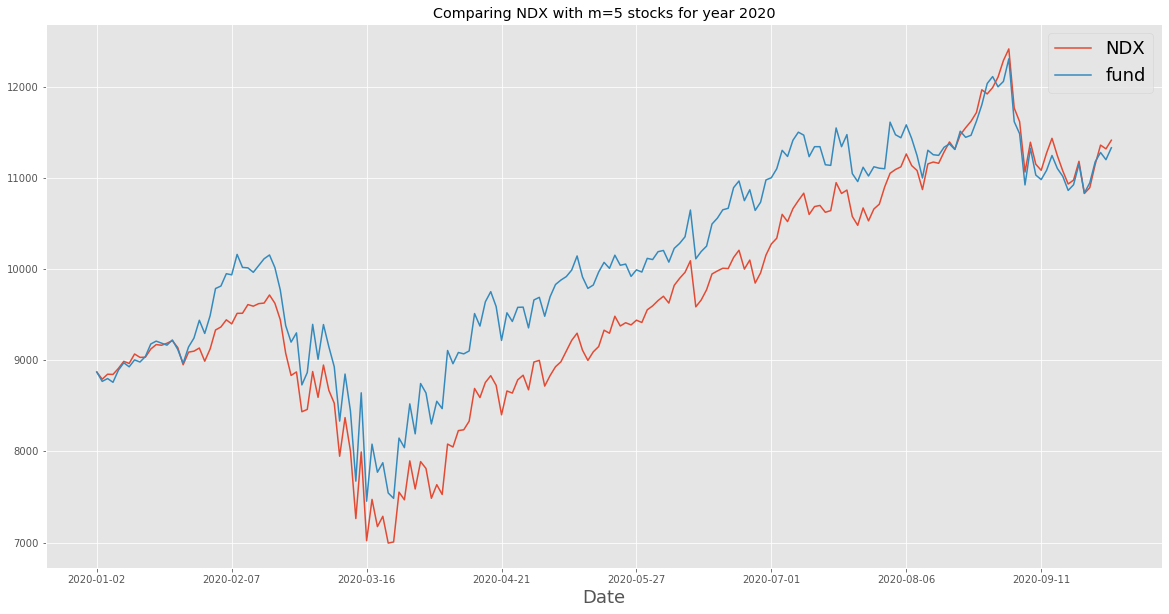

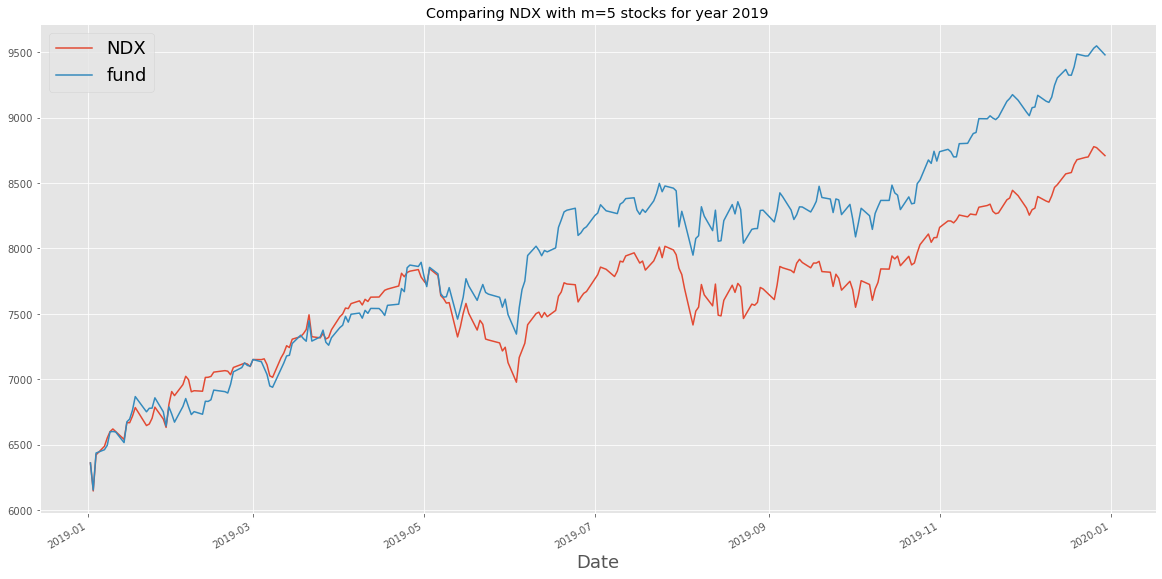

In [10]:
# Calculate tracking error for 2020 dataset using 'm' stock weights in the fund
track_error = portfolio_error(s_2020, weights)
track_portfolio(s_2020, weights, 2020)
print('Tracking error for 2020: ',track_error['diff'].sum())

# Calculate tracking error for 2019 dataset using 'm' stock weights in the fund
track_error = portfolio_error(input_stock, weights)
track_portfolio(input_stock, weights, 2019)
print('Tracking error for 2019: ',track_error['diff'].sum())

In [11]:
error_year_2020 = pd.Series([],dtype=float)
error_year_2019 = pd.Series([],dtype=float)

for m in range(10,input_stock.columns.shape[0],10):    
    final_stocks, obj_x = stock_selection(input_stock, m)
    solution = final_stocks.columns[obj_x[-final_stocks.shape[1]:]==1]

    weights,obj_val = calculated_weights(input_stock, m, solution)

    error_year_2020[m] = portfolio_error(s_2020, weights)['diff'].sum()
    error_year_2019[m] = portfolio_error(input_stock, weights)['diff'].sum()

In [12]:
error_year_2019

10     0.686533
20     0.478836
30     0.418015
40     0.370517
50     0.332540
60     0.344890
70     0.169824
80     0.147683
90     0.053779
100    0.044911
dtype: float64

In [13]:
error_year_2020

10     0.831317
20     0.652338
30     0.549085
40     0.587312
50     0.581148
60     0.819424
70     0.402497
80     0.386431
90     0.247582
100    0.249943
dtype: float64

In [14]:
# Plots portfolio errors
def portfolio_error_track(error_year_2019, error_year_2020, labels = None, title = None):
    errors = pd.concat([error_year_2019,error_year_2020], axis=1)
    if(labels == None):
        errors.columns = ['2019','2020']
    else:
        errors.columns = labels
    plt.style.use('ggplot')
    errors.plot(kind='line', figsize=(20,10))
    plt.legend(prop={'size': 18})
    if(title == None):
        plt.title(f'Tracking errors for 2019 and 2020')
    else:
        plt.title(title)
    plt.xlabel('Number of stocks in the fund', fontsize=18)

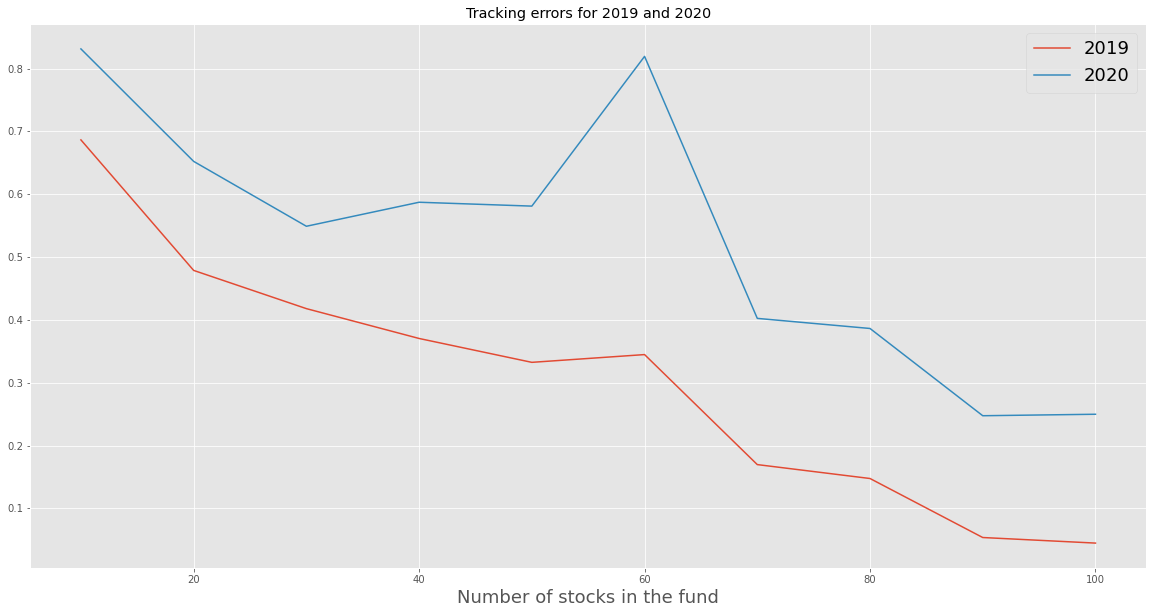

In [15]:
portfolio_error_track(error_year_2019, error_year_2020)

In [16]:
def full_portfolio(m):
    '''Creates a full portfolio with weights baesd upon minimizing difference in returns'''
    # Note, variable order is w1, w2, ... wn, y1,y2,...,yn, z1, z2, ... , zT
    # wi is the weight of stock i
    # yi = 1 if stock i is present in our portfolio, 0 otherwise \
    # zt represents the absolute error at time t

    # Sets up number of stocks and number of quarters
    n = input_stock.shape[1] -1
    if(n != 100):
        print("n is not 100")
    t = len(q2019)

    # Sets up sum(yi) constraint = m
    A = [[0]*(n) +[1]*n + [0]*t]
    sense = ["="]
    b = [m]

    # Sets up sum(wi) constraint = 1
    A.append([1]*n + [0]*(n+t))
    sense.append("=")
    b.append(1)
    

    for i in range(n):
        # Sets up wi < yi constraint
        temp = np.zeros(2*n + t)
        temp[i] = 1
        temp[n+i] = -1
        A.append(temp)
        b.append(0)
        sense.append("<")

    for i in range(t):
        # Sets up zi = abs(|qt - sum(wi rit)|) constraints
        temp1 = np.zeros(2*n + t)
        temp2 = np.zeros(2*n + t)
        temp1[0:n] = r2019.iloc[i].values
        temp2[0:n] = -r2019.iloc[i].values
        temp1[2*n + i] = 1
        temp2[2*n + i] = 1

        A.append(temp1)
        b.append(q2019.iloc[i])
        sense.append(">")

        A.append(temp2)
        b.append(-q2019.iloc[i])
        sense.append(">")
    
    A = np.matrix(A)

    # Setup Objective Value        
    obj = np.append(np.zeros(2*n), np.ones(t))

    # Setup Optimization Problem
    lpMod = gp.Model()
    lpMod.setParam('TimeLimit', GUROBI_TIMER)
    lpMod_x = lpMod.addMVar(n*2 + t,vtype = ["C"]*n + ["B"] * n + ["C"] * t)
    lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
    lpMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    # Solve Optimization Problem
    lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    lpMod.optimize()

    # Output file nicely
    return lpMod_x.x

In [17]:
# Obtain portfolios
pf = {}
for m in [5,10,20,30,40,50,60,70,80,90,100]:
    print("portfolio"+str(m)+".csv")
    try:
        pf[m] = pd.read_csv("portfolio" + str(m) + ".csv", index_col = "Unnamed: 0")
    except:
        pf[m] = pd.DataFrame(full_portfolio(m))
        pf[m].to_csv("portfolio"+str(m)+".csv")

portfolio5.csv
portfolio10.csv
portfolio20.csv
portfolio30.csv
portfolio40.csv
portfolio50.csv
portfolio60.csv
portfolio70.csv
portfolio80.csv
portfolio90.csv
portfolio100.csv


In [18]:
# Take raw output, & convert it into a standard dataframe portolio format
# Where the index column is the list of stocks, and other column is there weights.
n = input_stock.shape[1] -1
weight_m = {}
for m in [5,10,20,30,40,50,60,70,80,90,100]:
    mask = pf[m][pf[m].columns[0]][n:2*n] == 1
    mask = mask.reset_index(drop = True)
    weight_m[m] = pf[m][0:n][mask] 
    weight_m[m].index = (input_stock.drop("NDX",axis = 1).columns)[mask]

Tracking error for 2020:  0.24994327434030067
Tracking error for 2019:  0.04491081639360399


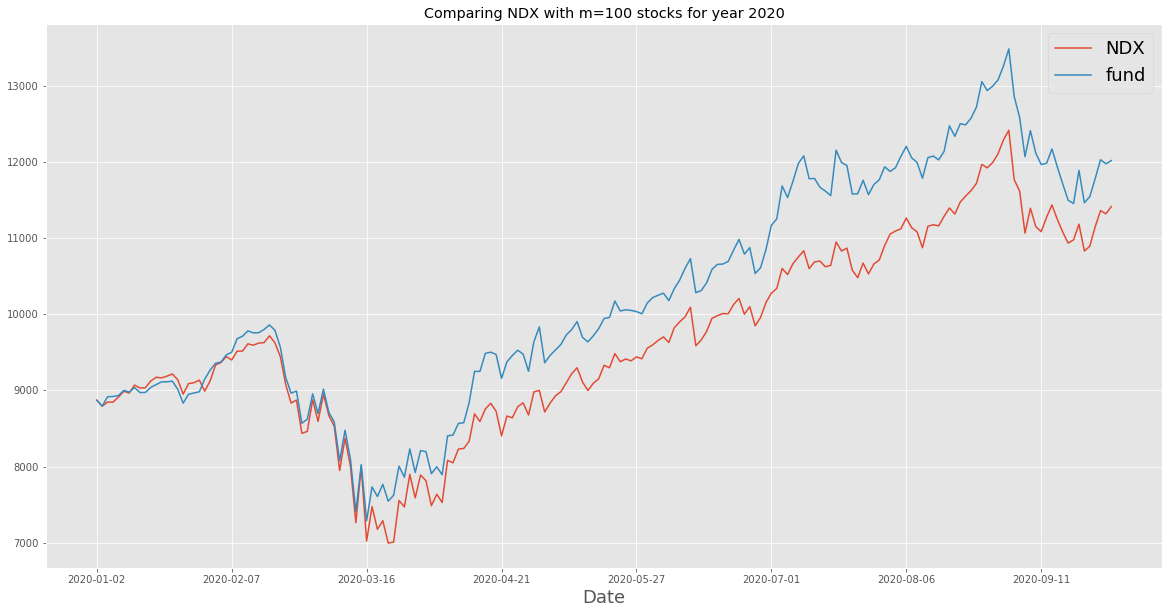

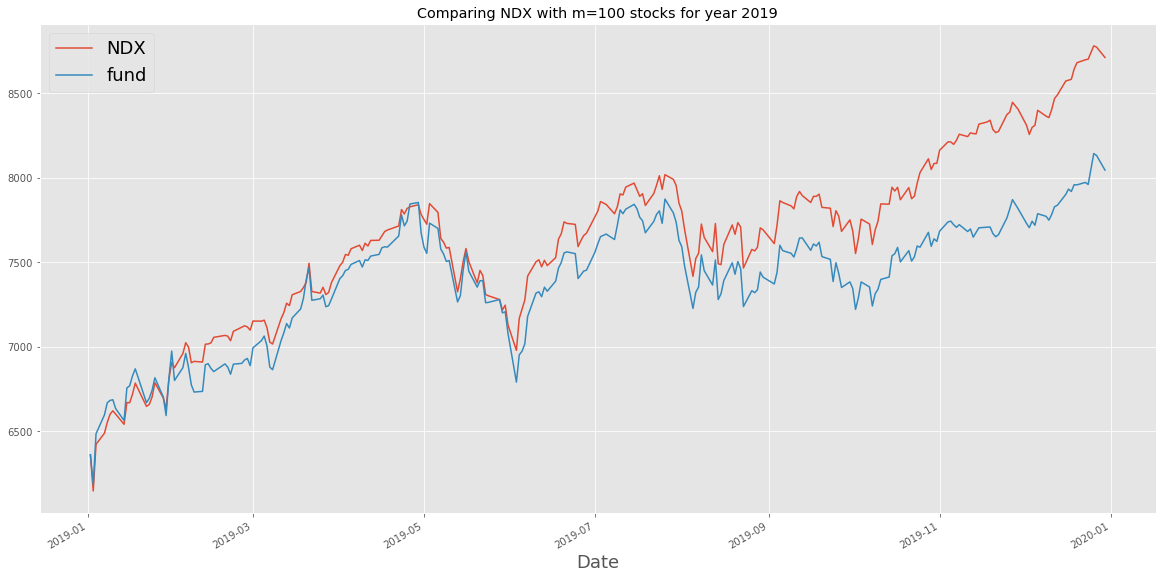

In [19]:
# Calculate tracking error for 2020 dataset using '5' stock weights in the fund
track_error = portfolio_error(s_2020, weights)
track_portfolio(s_2020, weights, 2020)
print('Tracking error for 2020: ',track_error['diff'].sum())

# Calculate tracking error for 2019 dataset using '5' stock weights in the fund
track_error = portfolio_error(input_stock, weights)
track_portfolio(input_stock, weights, 2019)
print('Tracking error for 2019: ',track_error['diff'].sum())

In [20]:
# Caculate the errors of our new portfolio by m

error_year_2020_2 = pd.Series([],dtype=float)
error_year_2019_2 = pd.Series([],dtype=float)

for m in [5,10,20,30,40,50,60,70,80,90,100]:    
    error_year_2020_2[m] = portfolio_error(s_2020, weight_m[m])['diff'].sum()
    error_year_2019_2[m] = portfolio_error(input_stock, weight_m[m])['diff'].sum()
    

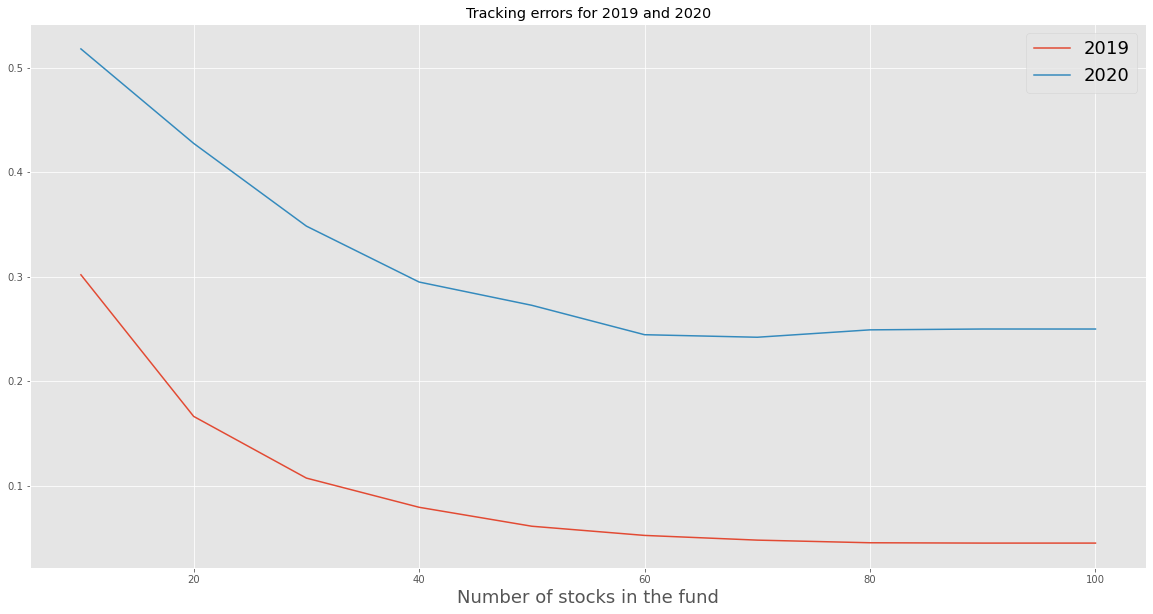

In [21]:
portfolio_error_track(error_year_2019_2[1:], error_year_2020_2[1:])

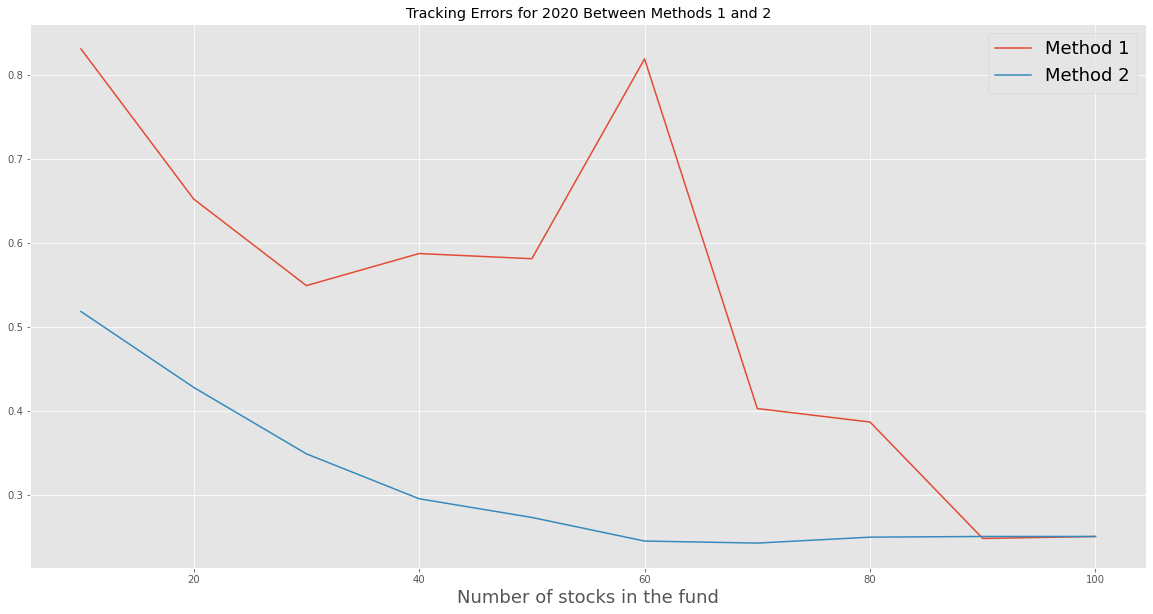

In [22]:
portfolio_error_track(error_year_2020, error_year_2020_2[1:], labels = ["Method 1", "Method 2"], title = "Tracking Errors for 2020 Between Methods 1 and 2")